In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
#Path management 

def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

# Check the directory
starting_directory_noe = 'C:/Users/Noe/source/repos/Energy-forecasting-NTNU/data/'
starting_directory_hugo = 'C:/Users/hugob/OneDrive/Documents/ENSE3/3A/lectures/Machine Learning/Project/git/Energy-forecasting-NTNU/data'
os.chdir(starting_directory_hugo)
list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Hugo
  File: notebook_hugo.ipynb
  File: read_files.ipynb
Directory: .\Noe
  File: Data_exploration.ipynb
  File: read_files.ipynb


In [3]:
#Load datasets #
#Targets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

# Train estimated data
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

# Train observed data
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

Train_datasets = [X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            X_train_estimated_a, X_train_estimated_b,X_train_estimated_c
            ]
Train_datasets_names = [ "X_train_observed_a", "X_train_observed_b", "X_train_observed_c",
                        "X_train_estimated_a", "X_train_estimated_b", "X_train_estimated_c"
                        ]

Target_datasets = [train_a, train_b, train_c]

### Quick data management for missing values

In [4]:
# Remove snow_density variable because too many Nan ==> Useless
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = 'snow_density:kgm3')
    Train_datasets[i] = dataset

In [5]:
# Function to fill gaps in dataset
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        method = 'ffill' # ffill: Propagate last valid observation forward to next valid
        new_column = Dataframe[feature].fillna(method='ffill')
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill' # bfill :Fill values by using the next valid observation to fill the gap.
            new_column = Dataframe[feature].fillna(method='bfill')
    
        if (np.any(new_column.isna()) == False):
            print("==> ", feature, " filled with ",method," method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values !!!")

In [6]:
# Fill for each train dataset for each variable where there is some Nan
for i, dataset in enumerate(Train_datasets):
    print("Dataset : ",  Train_datasets_names[i])
    nan_features = [var for var in dataset.columns if dataset[var].isnull().sum() > 0]
    for features in nan_features:
        fill_nan(dataset, features)
    print("\n")

Dataset :  X_train_observed_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method




### Feature engineering

In [7]:
# Check for correlation
set_nbr = 0
corr_matrix = Train_datasets[set_nbr].corr()
print(Train_datasets_names[set_nbr])
corr_matrix.style.background_gradient(cmap='coolwarm')

X_train_observed_a


c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
absolute_humidity_2m:gm3,1.000000,-0.804124,0.110840,0.352801,0.349927,0.024787,0.123430,0.974863,0.284847,0.291109,0.239287,0.243773,0.021256,nan,-0.119009,-0.069179,-0.148714,-0.085105,-0.098863,0.304652,-0.322754,0.147830,0.067724,-0.025242,0.165345,0.154403,-0.055802,0.261640,0.160016,0.143458,-0.203685,nan,-0.013563,0.034042,0.022875,0.432344,0.110364,0.900297,0.043038,-0.158686,-0.157917,0.050106,-0.258794,0.004869
air_density_2m:kgm3,-0.804124,1.000000,-0.159707,-0.473967,-0.463355,-0.105238,-0.060455,-0.838733,-0.402079,-0.415496,-0.393769,-0.409485,-0.067100,nan,0.063038,0.044146,0.075154,0.052815,0.058816,-0.386344,0.402335,0.280098,-0.084777,-0.012127,0.263756,0.275654,0.072122,-0.162900,0.141432,0.287484,0.316890,nan,0.013984,-0.065673,-0.067960,-0.504503,-0.063599,-0.915070,-0.103049,-0.011076,-0.017527,0.026196,0.142869,-0.000575
ceiling_height_agl:m,0.110840,-0.159707,1.000000,0.071831,0.066778,0.664970,0.037937,0.101108,0.055368,0.058749,0.236082,0.243613,-0.377015,nan,-0.018965,-0.010354,-0.026045,-0.014081,-0.016165,0.052470,-0.056461,0.097773,-0.012913,-0.063670,0.102267,0.099780,0.025814,-0.150385,-0.388320,0.097302,-0.061680,nan,-0.028779,-0.179834,0.040713,0.078340,-0.322444,0.255581,-0.187227,0.423864,-0.172588,-0.305707,-0.010682,-0.003096
clear_sky_energy_1h:J,0.352801,-0.473967,0.071831,1.000000,0.992332,0.053497,-0.080023,0.362016,0.911178,0.922412,0.719660,0.732282,0.002814,nan,-0.056605,-0.037862,-0.072751,-0.046583,-0.052732,0.650795,-0.690138,0.157747,-0.008042,-0.032567,0.160357,0.154124,-0.050700,0.054178,-0.339914,0.147883,-0.074640,nan,-0.020592,-0.039219,0.056788,0.847872,0.016904,0.438994,0.009891,0.092573,0.013025,0.069513,-0.343041,-0.005087
clear_sky_rad:W,0.349927,-0.463355,0.066778,0.992332,1.000000,0.050362,-0.079422,0.359138,0.917222,0.914733,0.727173,0.728482,0.003273,nan,-0.055061,-0.037588,-0.072560,-0.045965,-0.051830,0.651263,-0.693266,0.158353,-0.009060,-0.032314,0.160647,0.154566,-0.050494,0.052233,-0.313417,0.148472,-0.074147,nan,-0.020584,-0.041589,0.002422,0.851637,0.017788,0.424912,0.009648,0.083516,0.003153,0.063870,-0.327927,-0.006878
cloud_base_agl:m,0.024787,-0.105238,0.664970,0.053497,0.050362,1.000000,0.029038,0.018957,0.016105,0.019863,0.246256,0.252961,-0.394619,nan,-0.013806,-0.008638,-0.016642,-0.012054,-0.014636,0.027712,-0.029643,0.089278,-0.032314,-0.079654,0.092751,0.091005,0.031311,-0.117894,-0.467114,0.089255,-0.064314,nan,-0.019182,-0.134643,0.036471,0.048875,-0.274170,0.204864,-0.215561,0.449480,-0.208237,-0.377859,0.028942,0.001733
dew_or_rime:idx,0.123430,-0.060455,0.037937,-0.080023,-0.079422,0.029038,1.000000,0.123717,-0.080196,-0.081953,-0.055274,-0.056277,-0.050331,nan,-0.010698,-0.009383,-0.013659,-0.009211,-0.010723,-0.105438,0.102463,0.005786,-0.009744,-0.016899,0.009538,0.008596,-0.177816,-0.007136,0.100292,0.007660,-0.015160,nan,-0.003851,-0.022419,-0.039829,-0.072291,-0.036164,0.109030,-0.033482,-0.031053,-0.108146,-0.038802,0.005134,-0.001638
dew_point_2m:K,0.974863,-0.838733,0.101108,0.362016,0.359138,0.018957,0.123717,1.000000,0.296786,0.303062,0.245491,0.250216,0.059003,nan,-0.126655,-0.076161,-0.156335,-0.092939,-0.106866,0.310899,-0.329485,0.137601,0.065673,-0.025590,0.155653

In [207]:
#Find high correlated variables in train datasets
List_correlated_variable = []

for set_nbr in range(len(Train_datasets)):
    corr_matrix = Train_datasets[set_nbr].corr()
    threshold = 0.95

    idx = np.where((np.abs(corr_matrix) > threshold) & (corr_matrix !=1))
    print(round(idx[0].shape[0]/2)," strong correlation ==> \n")
    columns_corr = []
    ind_double = []

    # To select the correct variable (without time and time forecast in the pandaframe)
    if set_nbr > 2:
        add_int = 2
    else:
        add_int = 1

    for i in range(idx[0].shape[0]):
        if ( ind_double.count((idx[0][i],idx[1][i])) == 0):
            ind_double.append((idx[1][i],idx[0][i]))
            
            print( 
                    "Correlation between : ", 
                    Train_datasets[set_nbr].columns[idx[0][i]+add_int], "and", 
                    Train_datasets[set_nbr].columns[idx[1][i]+add_int], " = ",
                    corr_matrix.iloc[idx[0][i], idx[1][i]], "\n"
                )
            
            columns_corr.append((Train_datasets[set_nbr].columns[idx[0][i]+add_int],
                                Train_datasets[set_nbr].columns[idx[1][i]+add_int]
                                ))
            List_correlated_variable.append(columns_corr)

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.9748628282981654 

Correlation between :  clear_sky_energy_1h:J and clear_sky_rad:W  =  0.9923317834232241 

Correlation between :  diffuse_rad:W and diffuse_rad_1h:J  =  0.9869871153005173 

Correlation between :  direct_rad:W and direct_rad_1h:J  =  0.9852611696388884 

Correlation between :  msl_pressure:hPa and pressure_100m:hPa  =  0.9997717603345274 

Correlation between :  msl_pressure:hPa and pressure_50m:hPa  =  0.999914482392545 

Correlation between :  msl_pressure:hPa and sfc_pressure:hPa  =  0.9999042081912317 

Correlation between :  pressure_100m:hPa and pressure_50m:hPa  =  0.9999178389342016 

Correlation between :  pressure_100m:hPa and sfc_pressure:hPa  =  0.9996884691072808 

Correlation between :  pressure_50m:hPa and sfc_pressure:hPa  =  0.9999182187872183 

10  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.97361

We can see same correlation appears for all the datasets
==> Thus we can remove one of the varaible each time except for pressure variables which seem to be all correlated together

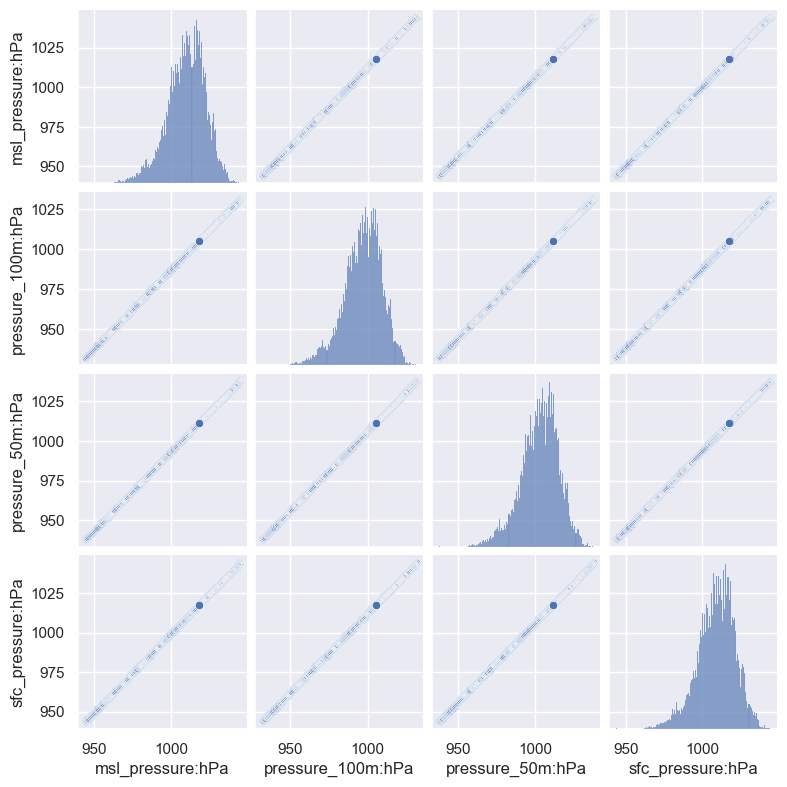

In [8]:
sns.set()
cols_pressure = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']
sns.pairplot(Train_datasets[0][cols_pressure], height = 2)
plt.show()

In [9]:
high_correlated_var_to_del = [
    "dew_point_2m:K",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa"
]
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = high_correlated_var_to_del)
    Train_datasets[i] = dataset

Goal : Get data into proper form to use it for training a maching learning algorithm
Issues : 
    1. Not same date between the three location
    2. Gap in target data
    3. Forecast data has one more feature than observed data (Forecast time)
    4. Not the same time step in observed and forcast data
  
  Ideas to solve them (simpliest ones):
    1. Reduce dataset to the most restrictive dataset
    2. Get the data from the same date previous or next year
    3. Don't take into account forecast time feature
    4. Make an average over 4hours of each feature

Try to solve problem 2

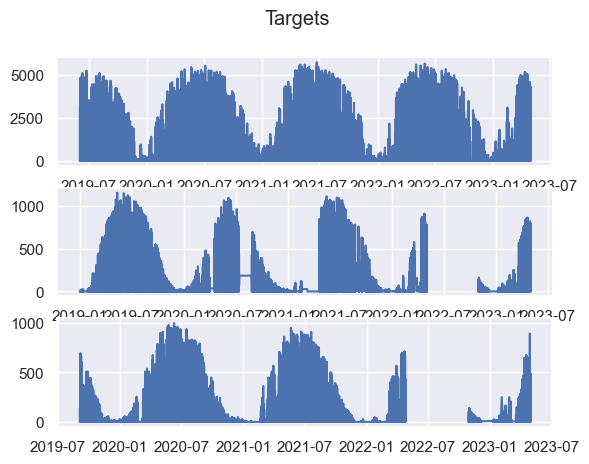

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Targets')
ax1.plot(train_a.iloc[:,0], train_a.iloc[:,1])
ax2.plot(train_b.iloc[:,0], train_b.iloc[:,1])
ax3.plot(train_c.iloc[:,0], train_c.iloc[:,1])
plt.show()

In [45]:
location = ["A", "B", "C"]
for i in range(3):
    print("Location ", location[i])
    print("Observed data : ", Train_datasets[i].iloc[0,0]," to ", Train_datasets[i].iloc[-1,0], " ,size = ",Train_datasets[i].shape )
    print("Forecast data : ", Train_datasets[i+3].iloc[0,0]," to ", Train_datasets[i+3].iloc[-1,0],  " ,size = ",Train_datasets[i+3].shape)
    print("Target : ", Target_datasets[i].iloc[0,0]," to ", Target_datasets[i].iloc[-1,0],  " ,size = ",Target_datasets[i].shape )
    print("Missing values in target =", np.any(Target_datasets[i].isna()))
    print("Zero values in target = ", np.any(Target_datasets[i] == 0) )
    print("\n")

Location  A
Observed data :  2019-06-02 22:00:00  to  2022-10-21 01:00:00  ,size =  (118669, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2019-06-02 22:00:00  to  2023-04-30 23:00:00  ,size =  (34085, 2)
Missing values in target = False
Zero values in target =  True


Location  B
Observed data :  2019-01-01 00:00:00  to  2022-05-03 00:00:00  ,size =  (116929, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32848, 2)
Missing values in target = True
Zero values in target =  True


Location  C
Observed data :  2019-01-01 00:00:00  to  2022-05-01 22:00:00  ,size =  (116825, 38)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 39)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32155, 2)
Missing values in target = True
Zero values in target =  True




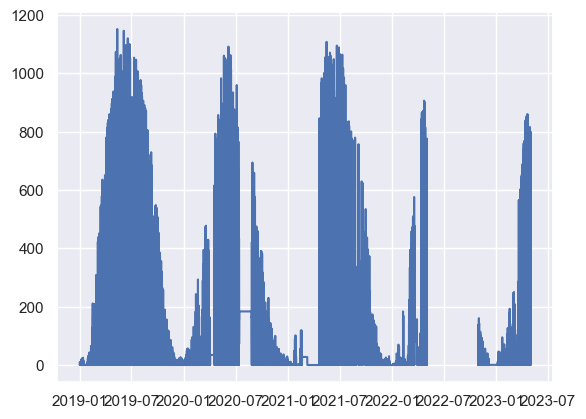

In [56]:
plt.plot(Target_datasets[1].iloc[:,0], Target_datasets[1].iloc[:,1] )
plt.show()

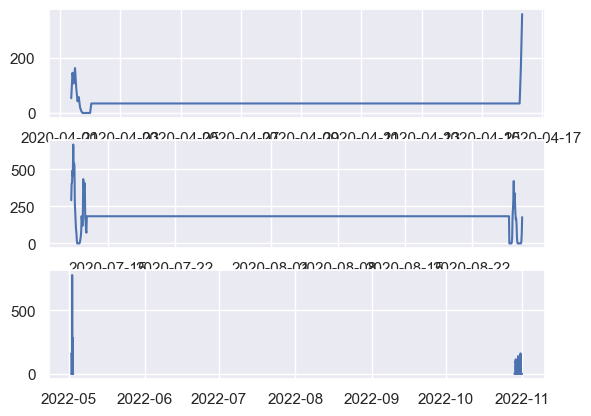

In [95]:
idx1_gap = (10950,11310)
idx2_gap = (13370,14500)
idx3_gap = (29200,29300)
f, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(Target_datasets[1].iloc[idx1_gap[0]:idx1_gap[1],0], Target_datasets[1].iloc[idx1_gap[0]:idx1_gap[1],1] )
ax2.plot(Target_datasets[1].iloc[idx2_gap[0]:idx2_gap[1],0], Target_datasets[1].iloc[idx2_gap[0]:idx2_gap[1],1] )
ax3.plot(Target_datasets[1].iloc[idx3_gap[0]:idx3_gap[1],0], Target_datasets[1].iloc[idx3_gap[0]:idx3_gap[1],1] )
plt.show()

In [121]:
#Find gaps
thershold_gap = 3600 
gap_time_1 = np.where((Target_datasets[0].diff().iloc[:,0].dt.seconds > thershold_gap) == True)
gap_time_2 = np.where((Target_datasets[1].diff().iloc[:,0].dt.seconds > thershold_gap) == True)
gap_time_3 = np.where((Target_datasets[2].diff().iloc[:,0].dt.seconds > thershold_gap) == True)

In [130]:
#Gap in first target dataset
print(Target_datasets[0].iloc[gap_time_1[0][0]-1:gap_time_1[0][0]+1,0])

29666   2022-10-21 00:00:00
29667   2022-10-28 22:00:00
Name: time, dtype: datetime64[ns]


In [155]:
#Select date and take the same date but one year before
begin = Target_datasets[0].iloc[gap_time_1[0][0]-1,0]
end = Target_datasets[0].iloc[gap_time_1[0][0]+1,0]

new_end = end.replace(year= end.year -1)
new_begin = begin.replace(year=begin.year -1)

#Take the data from one year before
replacement = Target_datasets[0][(Target_datasets[0]['time'] >= new_begin) & (Target_datasets[0]['time'] < new_end)]
#Check if gap previous year before replacement
if (np.any((replacement.diff().iloc[:,0].dt.seconds > thershold_gap) == True) != False):
    print("Error")
else:
    print("cc")

cc


In [161]:
test = Target_datasets[0].reset_index().set_index('time').resample('1H')
    

In [170]:
test = Target_datasets[0].resample('60min', on='time')

In [171]:
gap_time_1 = np.where((test.diff().iloc[:,0].dt.seconds > thershold_gap) == True)


AttributeError: 'DatetimeIndexResampler' object has no attribute 'diff'

In [169]:
Target_datasets[0]

,time,pv_measurement
0,2019-06-02 22:00:00,0.00
1,2019-06-02 23:00:00,0.00
2,2019-06-03 00:00:00,0.00
3,2019-06-03 01:00:00,0.00
4,2019-06-03 02:00:00,19.36
...,...,...
34080,2023-04-30 19:00:00,9.02
34081,2023-04-30 20:00:00,0.00
34082,2023-04-30 21:00:00,0.00
34083,2023-04-30 22:00:00,0.00
